# Elo Ratings

In this notebook we will try to work through the mathematics behind the Elo rating system.

## 1. Modeling your ability as a normal distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In the Elo rating system, your ability in the game is modeled as a normal distribution. Most of the time you will perform around the mean of the distribution, but every now and then you have a very good or a very bad day and score a bit higher or lower.

So let's start by plotting a normal distribution

In [2]:
def gaussian(mean: float, std: float, xs: np.ndarray) -> np.ndarray:
    ys = np.exp(-((xs - mean)**2) / (2*(std**2))) / (std * np.sqrt(2 * np.pi))
    return ys

# For noe we will assume a certain standard deviation. We will think about how to set this value in a more meaningful way later.
INITIAL_STD = 100

In [3]:
# Let's say player a has a mean score of 1100
mean_score_a = 1100
xs = np.linspace(start=500, stop=1500, num=1001)
score_distribution_a = gaussian(mean=mean_score_a, std=INITIAL_STD, xs=xs)

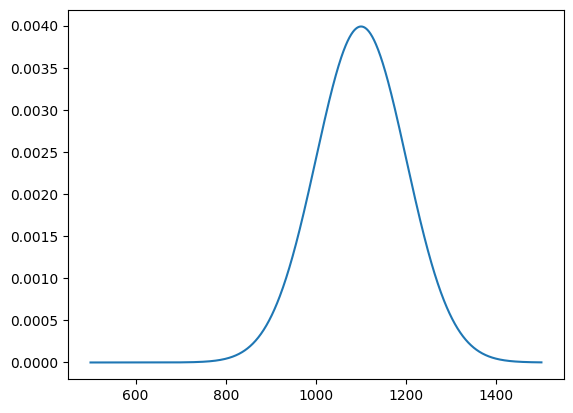

In [4]:
plt.plot(xs, score_distribution_a)
plt.show()

To make it a little easier to reason about these scores we can discretize this continuous distribution. This will allow us to make statements like:
- Given my mean score and std, the probability of performing anywhere between scores 1200 and 1250 is 0.1

In [5]:
def discretize_distribution(bin_size: int, xs: np.ndarray, score_distribution: np.ndarray):
    xs = xs.tolist()
    score_distribution = score_distribution.tolist()

    idx = 1

    new_xs = []
    new_ys = []

    while idx < len(xs):
        # The new_xs array will contains the scores that are the lower boundary of the bin
        new_xs.append(xs[idx])

        # For every bin, we integrate the curve to get the probability of drawing a number from that bin
        integrated_score = 0
        bin_dx = 0
        while bin_dx < bin_size:
            dx = xs[idx] - xs[idx - 1]
            bin_dx += dx
            integrated_score += score_distribution[idx] * dx

            idx += 1

        new_ys.append(integrated_score)

    new_xs = np.array(new_xs) + 0.5 * bin_size - 1  # Add half the bin_size, so that this array will contain the centers of the bin, rather than the lower boundary
    new_ys = np.array(new_ys)
    return new_xs, new_ys

In [6]:
new_xs, new_ys = discretize_distribution(bin_size=50, xs=xs, score_distribution=score_distribution_a)

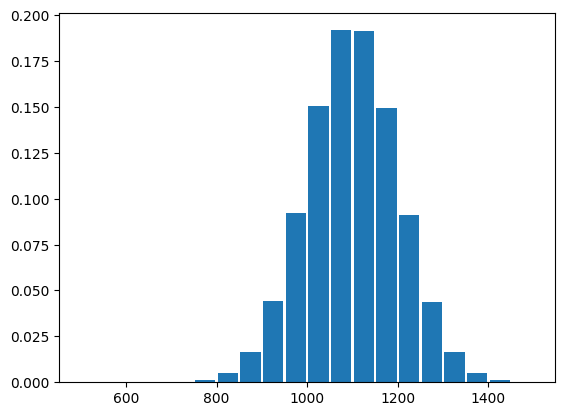

0.999968992431114 should still be approximately equal to 1


In [7]:
plt.bar(new_xs, new_ys, width=45, align='center')
plt.show()

print(f'{new_ys.sum()} should still be approximately equal to 1')

## 2. Calculating the expected outcome of a game given two normal distributions

In [8]:
def expected_outcome_of_win_for_score(mean_score_a: int, std_a: int, score_b: int) -> float:
    '''
    An expected outcome of 1 means that player b will always win from player a. An expected
    outcome of 0 mean that player b will always lose from player a.
    '''
    xs = np.linspace(start=500, stop=1500, num=1001)
    score_distribution_a = gaussian(mean=mean_score_a, std=std_a, xs=xs)
    new_xs, scores_a = discretize_distribution(bin_size=50, xs=xs, score_distribution=score_distribution_a)

    losses_for_a = []
    for score_a in new_xs.tolist():
        if score_a < score_b:
            losses_for_a.append(1)  # Player b wins
        if score_a == score_b:
            losses_for_a.append(0.5)  # It's a tie!
        if score_a > score_b:
            losses_for_a.append(0)  # Player a wins
    
    expected_outcome = (np.array(losses_for_a) * scores_a).sum()
    return expected_outcome

In [9]:
test_scores = [900, 1000, 1100, 1200, 1300]
for score_b in test_scores:
    print(f'Elo of {score_b} against {mean_score_a} has a probability of ' + 
        f'winning of: {round(expected_outcome_of_win_for_score(mean_score_a=mean_score_a, std_a=INITIAL_STD, score_b=score_b), 2)}')

Elo of 900 against 1100 has a probability of winning of: 0.02
Elo of 1000 against 1100 has a probability of winning of: 0.16
Elo of 1100 against 1100 has a probability of winning of: 0.5
Elo of 1200 against 1100 has a probability of winning of: 0.84
Elo of 1300 against 1100 has a probability of winning of: 0.98


In [10]:
def expected_outcome_of_win_for_mean_score(mean_score_a: int, std_a: int, mean_score_b: int, std_b) -> float:
    '''
    An expected outcome of 1 means that player b will always win from player a. An expected
    outcome of 0 mean that player b will always lose from player a.
    '''
    xs = np.linspace(start=500, stop=1500, num=1001)
    score_distribution_b = gaussian(mean=mean_score_b, std=std_b, xs=xs)
    new_xs, scores_b = discretize_distribution(bin_size=50, xs=xs, score_distribution=score_distribution_b)

    all_outcomes = []
    for idx, score_b in enumerate(new_xs.tolist()):
        expected_outcome = expected_outcome_of_win_for_score(mean_score_a=mean_score_a, std_a=std_a, score_b=score_b)
        all_outcomes.append(expected_outcome)

    all_outcomes = np.array(all_outcomes)
    expected_outcome = (all_outcomes * scores_b).sum()
    return expected_outcome

In [11]:
test_scores = [900, 1000, 1100, 1200, 1300]
for mean_score_b in test_scores:
    print(f'Elo of {mean_score_b} against {mean_score_a} has a probability of ' + 
        f'winning of: {round(expected_outcome_of_win_for_mean_score(mean_score_a=mean_score_a, std_a=INITIAL_STD, mean_score_b=mean_score_b, std_b=INITIAL_STD), 2)}')

Elo of 900 against 1100 has a probability of winning of: 0.08
Elo of 1000 against 1100 has a probability of winning of: 0.24
Elo of 1100 against 1100 has a probability of winning of: 0.5
Elo of 1200 against 1100 has a probability of winning of: 0.75
Elo of 1300 against 1100 has a probability of winning of: 0.89


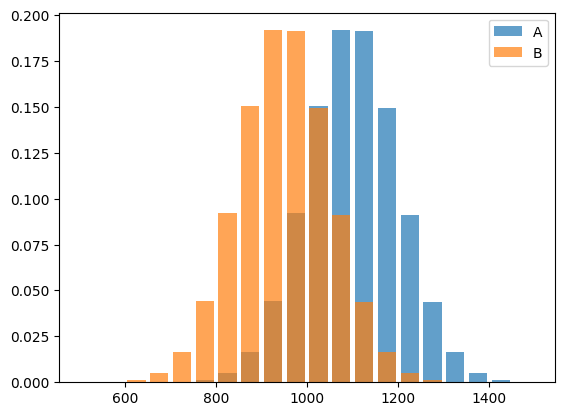

The probability of player B winning from player A is:
0.15


In [12]:
xs = np.linspace(start=500, stop=1500, num=1001)
score_distribution_a = gaussian(mean=1100, std=INITIAL_STD, xs=xs)
score_distribution_b = gaussian(mean=950, std=INITIAL_STD, xs=xs)

new_xs, probabilities_a = discretize_distribution(bin_size=50, xs=xs, score_distribution=score_distribution_a)
new_xs, probabilities_b = discretize_distribution(bin_size=50, xs=xs, score_distribution=score_distribution_b)

plt.bar(new_xs, probabilities_a, width=40, alpha=0.7, label='A')
plt.bar(new_xs, probabilities_b, width=40, alpha=0.7, label='B')
plt.legend()
plt.show()

print('The probability of player B winning from player A is:')
print(round(expected_outcome_of_win_for_mean_score(mean_score_a=1100, std_a=INITIAL_STD, mean_score_b=950, std_b=INITIAL_STD), 2))